# Discover the Higgs with Deep Neural Networks
# Create Baseline Model

Now it is your turn to create your own model to hunt for the Higgs boson. For the beginning, we will have a look on a baseline model. This baseline model does already a good job in the classification and it is up to you to create a better one.

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from numpy.random import seed
import os

# Import the tensorflow module to create a neural network
import tensorflow as tf
from tensorflow.data import Dataset

# Import function to split data into train and test data
from sklearn.model_selection import train_test_split

# Import the kFold module for cross-validation
from sklearn.model_selection import KFold

# Import some common functions created for this notebook
import common

# Random state
random_state = 21
_ = np.random.RandomState(random_state)

## Data Preparation

### Load the Data

In [2]:
# Define the input samples
sample_list_signal = ['ggH125_ZZ4lep', 'VBFH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
sample_list_background = ['llll', 'Zee', 'Zmumu', 'ttbar_lep']

In [3]:
sample_path = 'input'
# Read all the samples
no_selection_data_frames = {}
for sample in sample_list_signal + sample_list_background:
    no_selection_data_frames[sample] = pd.read_csv(os.path.join(sample_path, sample + '.csv'))

### Event Pre-Selection

Import the pre-selection functions saved during the first chapter. If the modules are not found solve and execute the notebook of the first chapter.

In [4]:
from functions.selection_lepton_charge import selection_lepton_charge
from functions.selection_lepton_type import selection_lepton_type

In [5]:
# Create a copy of the original data frame to investigate later
data_frames = no_selection_data_frames.copy()

# Apply the chosen selection criteria
for sample in sample_list_signal + sample_list_background:
    # Selection on lepton type
    type_selection = np.vectorize(selection_lepton_type)(
        data_frames[sample].lep1_pdgId,
        data_frames[sample].lep2_pdgId,
        data_frames[sample].lep3_pdgId,
        data_frames[sample].lep4_pdgId)
    data_frames[sample] = data_frames[sample][type_selection]

    # Selection on lepton charge
    charge_selection = np.vectorize(selection_lepton_charge)(
        data_frames[sample].lep1_charge,
        data_frames[sample].lep2_charge,
        data_frames[sample].lep3_charge,
        data_frames[sample].lep4_charge)
    data_frames[sample] = data_frames[sample][charge_selection]

### Get Training and Test Data

In [6]:
# Split data to keep 40% for testing
train_data_frames, test_data_frames = common.split_data_frames(data_frames, 0.6)

Import the reweighting function to train with event weights. If the module is not found solve and execute the notebook of chapter 5.

In [7]:
from functions.reweight_weights import reweight_weights

## Baseline Model

In [8]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']
training_variables += ['lep1_e', 'lep2_e', 'lep3_e', 'lep4_e']
training_variables += ['lep1_charge', 'lep2_charge', 'lep3_charge', 'lep4_charge']
training_variables += ['lep1_pdgId', 'lep2_pdgId', 'lep3_pdgId', 'lep4_pdgId']
training_variables += ['lep1_phi', 'lep2_phi', 'lep3_phi', 'lep4_phi']
training_variables += ['lep1_eta', 'lep2_eta', 'lep3_eta', 'lep4_eta']

In [9]:
# Extract the values, weights, and classification of the data
values, weights, classification = common.get_dnn_input(train_data_frames, training_variables, sample_list_signal, sample_list_background)

In [10]:
# Split into train and validation data
train_values, val_values, train_classification, val_classification = train_test_split(values, classification, test_size=1/3, random_state=random_state)
train_weights, val_weights = train_test_split(weights, classification, test_size=1/3, random_state=random_state)[:2]

In [11]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Optimizer
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.9)

In [12]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=random_state)

In [15]:
# Store the models and their training history
kfold_history = []
kfold_model = []
# Store the evaluation on training and validation data
kfold_train_eval_loss = []
kfold_train_eval_acc = []
kfold_val_eval_loss = []
kfold_val_eval_acc = []
split_idx = 1
for train_indices, val_indices in kfold.split(values):
    print(f'Use fold {split_idx}')
    split_idx += 1
    # Get train and validation data 
    train_values = values[train_indices]
    train_classification = classification[train_indices]
    train_weights = weights[train_indices]
    val_values = values[val_indices]
    val_classification = classification[val_indices]
    val_weights = weights[val_indices]
    # Get reweighted weights
    train_weights_reweighted = reweight_weights(train_weights, train_classification)
    val_weights_reweighted = reweight_weights(val_weights, val_classification)
    # Get train and validation datasets
    train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
    train_data = train_data.shuffle(len(train_data), seed=random_state)
    train_data = train_data.batch(124)
    val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
    val_data = val_data.shuffle(len(val_data), seed=random_state)
    val_data = val_data.batch(124)

    # Normalization layer
    normalization_layer = tf.keras.layers.Normalization()
    normalization_layer.adapt(train_values)
    # Create a simple NN
    model_layers = [
        normalization_layer,
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]
    model = tf.keras.models.Sequential(model_layers)
    # Compile model
    model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

    # Train model
    history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

    # Append to list
    kfold_history.append(history)
    kfold_model.append(model)

    # Evaluate model on training and validation data
    model_train_evaluation = model.evaluate(train_data)
    model_val_evaluation = model.evaluate(val_data)
    kfold_train_eval_loss.append(model_train_evaluation[0])
    kfold_train_eval_acc.append(model_train_evaluation[1])
    kfold_val_eval_loss.append(model_val_evaluation[0])
    kfold_val_eval_acc.append(model_val_evaluation[1])

Use fold 1


2023-06-08 15:44:24.614596: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.5925 - binary_accuracy: 0.6950 - val_loss: 0.5540 - val_binary_accuracy: 0.7394
Epoch 2/1000
2889/2889 [==============================] - 3s 965us/step - loss: 0.5297 - binary_accuracy: 0.7452 - val_loss: 0.5113 - val_binary_accuracy: 0.7651
Epoch 3/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.4841 - binary_accuracy: 0.7818 - val_loss: 0.4735 - val_binary_accuracy: 0.7858
Epoch 4/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.4461 - binary_accuracy: 0.8005 - val_loss: 0.4401 - val_binary_accuracy: 0.7969
Epoch 5/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.4162 - binary_accuracy: 0.8179 - val_loss: 0.4238 - val_binary_accuracy: 0.8077
Epoch 6/1000
2889/2889 [==============================] - 3s 1ms/step - loss: 0.3939 - binary_accuracy: 0.8298 - val_loss: 0.4056 - val_binary_accuracy: 0.8124
Epoch 7/1000
2889/2889 [==============

2889/2889 [==============================] - 4s 1ms/step - loss: 0.2732 - binary_accuracy: 0.8981 - val_loss: 0.3303 - val_binary_accuracy: 0.8680
Epoch 20/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2672 - binary_accuracy: 0.9028 - val_loss: 0.3312 - val_binary_accuracy: 0.8694
Epoch 21/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2634 - binary_accuracy: 0.9010 - val_loss: 0.3274 - val_binary_accuracy: 0.8708
Epoch 22/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2595 - binary_accuracy: 0.9060 - val_loss: 0.3218 - val_binary_accuracy: 0.8698
Epoch 23/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2544 - binary_accuracy: 0.9077 - val_loss: 0.3215 - val_binary_accuracy: 0.8734
Epoch 24/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2511 - binary_accuracy: 0.9079 - val_loss: 0.3170 - val_binary_accuracy: 0.8760
Epoch 25/1000
2889/2889 [=======================

Epoch 32/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2258 - binary_accuracy: 0.9223 - val_loss: 0.2791 - val_binary_accuracy: 0.8941
Epoch 33/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2225 - binary_accuracy: 0.9250 - val_loss: 0.2818 - val_binary_accuracy: 0.8926
Epoch 34/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2210 - binary_accuracy: 0.9220 - val_loss: 0.2778 - val_binary_accuracy: 0.8969
Epoch 35/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2177 - binary_accuracy: 0.9256 - val_loss: 0.2787 - val_binary_accuracy: 0.8948
Epoch 36/1000
2889/2889 [==============================] - 5s 1ms/step - loss: 0.2161 - binary_accuracy: 0.9258 - val_loss: 0.2774 - val_binary_accuracy: 0.8966
Epoch 37/1000
2889/2889 [==============================] - 4s 1ms/step - loss: 0.2141 - binary_accuracy: 0.9279 - val_loss: 0.2775 - val_binary_accuracy: 0.8961
Epoch 38/1000
2889/2889 [=========

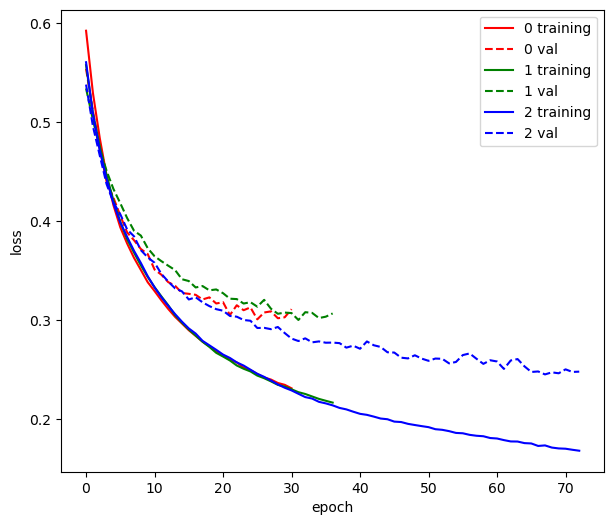

In [19]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
color_list = ['r', 'g', 'b']
for k_fold_idx, (history, color) in enumerate(zip(kfold_history, color_list)):
  ax.plot(history.history['loss'], color=color, label=f'{k_fold_idx} training')
  ax.plot(history.history['val_loss'], color=color, ls='--', label=f'{k_fold_idx} val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
plt.savefig(f'baseline_models/training_history.png', dpi=300, bbox_inches='tight')
_ = plt.show()

In [17]:
val_loss_mean = np.mean(kfold_val_eval_loss)
val_loss_std = np.std(kfold_val_eval_loss)
print(f'The val loss of the model is {round(val_loss_mean, 3)} +- {round(val_loss_std, 3)}')

The val loss of the model is 0.282 +- 0.026


## Save the Models

In [18]:
# Loop over all cross-validation models
for idx, model in enumerate(kfold_model):
    # Save the model
    model.save(f'baseline_models/model_crossval{idx}')

INFO:tensorflow:Assets written to: baseline_models/model_crossval0/assets
INFO:tensorflow:Assets written to: baseline_models/model_crossval1/assets
INFO:tensorflow:Assets written to: baseline_models/model_crossval2/assets
